<h1>CD3 Population</h1>

In [5]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.transforms import apply_transform
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from datetime import datetime
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
warnings.filterwarnings('ignore')
test_init()

In [2]:
def visualise_manual_threshold(sample_go, parent_population, x, t, xlim, ylim):
    data = apply_transform(sample_go.get_population_df(parent_population).copy(), [x], 'logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data['SSC-A'], bins=500, norm=LogNorm())
    ax.axvline(t, c='r')
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

<h2>Manual Gating</h2>

In [3]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [4]:
hc = Gating(exp, 'hc1')

In [6]:
for x in ['debris', 'cells', 'lymp']:
    hc.populations.pop('debris')

{'root': Node('/root', geom={'shape': None, 'x': 'FSC-A', 'y': 'SSC-A'}, index=array([      0,       1,       2, ..., 1184875, 1184876, 1184877]), prop_of_parent=1.0, prop_of_total=1.0, warnings=[]),
 'cells': Node('/root/cells', geom={'x_min': 62447.01953125, 'x_max': 262143.0, 'y_min': 20600.599609375, 'y_max': 262143.0, 'shape': 'rect', 'x': 'FSC-A', 'y': 'SSC-A'}, index=array([      0,       1,       2, ..., 1184875, 1184876, 1184877]), prop_of_parent=0.9599781580888497, prop_of_total=0.9599781580888497, warnings=[]),
 'debris': Node('/root/debris', geom={'x_min': 62447.01953125, 'x_max': 262143.0, 'y_min': 20600.599609375, 'y_max': 262143.0, 'shape': 'rect', 'x': 'FSC-A', 'y': 'SSC-A'}, index=array([      4,      10,      27, ..., 1184693, 1184755, 1184804]), prop_of_parent=0.040021841911150345, prop_of_total=0.040021841911150345, warnings=[]),
 'lymphocytes': Node('/root/cells/lymphocytes', geom={'centroid': [105182.5217438198, 40031.17768641808], 'width': 46871.44816185313, 'hei

In [ ]:
child_populations = ChildPopulationCollection('geom')

In [6]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

In [7]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

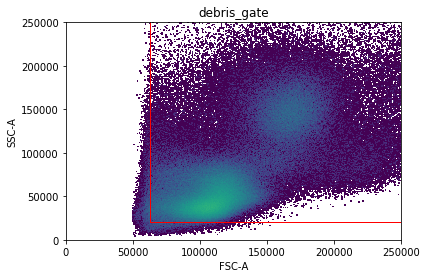

In [8]:
hc.apply('debris_gate')

In [9]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('lymphocytes', definition='+')
child_populations.add_population('other_cells', definition='-')

In [10]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc.create_gate(gate_name='lymphocyte_gate', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

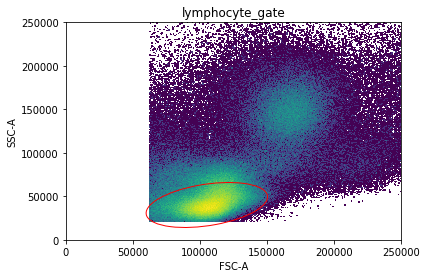

In [11]:
hc.apply('lymphocyte_gate')

In [40]:
hc.gates['lymphocyte_gate']

<Gate: Gate object>

In [12]:
hc.save()

InvalidDocument: cannot encode object: <immunova.flow.gating.defaults.ChildPopulationCollection object at 0x7f49e51fbe10>, of type: <class 'immunova.flow.gating.defaults.ChildPopulationCollection'>

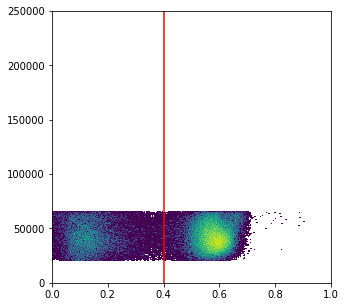

In [21]:
visualise_manual_threshold(hc, 'lymphocytes', 'CD3', 0.4, (0, 1), (0,250000))

In [ ]:
child_populations = ChildPopulationCollection('threshold_1d')
child_populations.add_population('CD3+', definition='+')
child_populations.add_population('other_cells', definition='-')